In [2]:
import os
import glob
from datetime import datetime
from collections import defaultdict

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy.ndimage import maximum_filter

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('error', category=UserWarning)

In [3]:
rrdp_dir = '../SAGE_RRDP/s_rrdp_v01_fv01'
coll_dir = './collocated'

rrdp_files = sorted(glob.glob(os.path.join(rrdp_dir, '*_N_*.nc')))
rrdp_dates = [datetime.strptime(os.path.basename(f).split('_')[0], '%Y%m%d') for f in rrdp_files]
coll_files = [f'{coll_dir}/{d.strftime("%Y")}/lagrangian_{d.strftime("%Y%m%d")}.nc' for d in rrdp_dates]
rrdp_coll_date_files = [(date, rf, cf) for date, rf, cf in zip(rrdp_dates, rrdp_files, coll_files) if os.path.exists(cf)]
len(rrdp_coll_date_files), rrdp_coll_date_files[0]

(2688,
 (datetime.datetime(2012, 1, 2, 0, 0),
  '../SAGE_RRDP/s_rrdp_v01_fv01/20120102_N_v01_fv01.nc',
  './collocated/2012/lagrangian_20120102.nc'))

In [4]:
rrdp_icetypes = ['icetype_matches', 'NIC_dom_icetype', 'autoDMI_dom_icetype', 'AARI_dom_icetype', 'CIS_dom_icetype']
lagr_algos = ['lm', 'newdc', 'nsidc']

min_size = 0
scores_list = defaultdict(list)
comas = defaultdict(list)
for date, rf, cf in tqdm(rrdp_coll_date_files):
    ice_type = {}
    with xr.open_dataset(rf) as ds:
        for rrdp_icetype in rrdp_icetypes:
            if rrdp_icetype in ds:
                ice_type[rrdp_icetype] = ds[rrdp_icetype][0].values
    
    with xr.open_dataset(cf) as ds:
        for lagr_algo in lagr_algos:
            ice_type[lagr_algo] = ds[f'{lagr_algo}_ice_type'][0].values
        
    # convert to FYI/MYI only
    for name in ice_type:
        ice_type[name][ice_type[name] == 1] = 2
        ice_type[name][ice_type[name] == 3] = 4
    
    coll_mask = np.isfinite(ice_type['lm']) & (ice_type['lm'] > 0) & (ice_type['newdc'] > 0) & (ice_type['nsidc'] > 0)
    for name in rrdp_icetypes:
        if name not in ice_type:
            continue
        rrdp_mask = np.isfinite(ice_type[name]) & (ice_type[name] > 0)
        comm_mask = coll_mask & rrdp_mask

        if np.sum(comm_mask) < min_size:
            continue

        coma_vec = []
        scores_vec = []
        for algo in lagr_algos:
            coma = confusion_matrix(
                ice_type[name][comm_mask],
                ice_type[algo][comm_mask], labels=[2, 4])
            if np.any(np.sum(coma, axis=1) == 0):
                continue
            coma_normalized = coma.astype('float') / coma.sum(axis=1)[:, np.newaxis]
            accuracy = np.trace(coma) / np.sum(coma)
            balanced_accuracy = np.mean(np.diag(coma_normalized))
            coma_vec.append(coma)
            scores_vec.extend([accuracy, balanced_accuracy])
        
        if len(coma_vec) < len(lagr_algos):
            continue
        comas[name].append(coma_vec)
        scores_list[name].append((date, *scores_vec, np.sum(comm_mask)))



100%|██████████| 2688/2688 [03:04<00:00, 14.60it/s]


In [5]:
scores = dict()
for name in scores_list:
    scores[name] = pd.DataFrame(scores_list[name], columns=['date', 'acc_lm', 'bac_lm', 'acc_newdc', 'bac_newdc', 'acc_nsidc', 'bac_nsidc', 'count'])
    scores[name].set_index('date', inplace=True)
    comas[name] = np.array(comas[name])  # shape (time, 4, 2, 2)

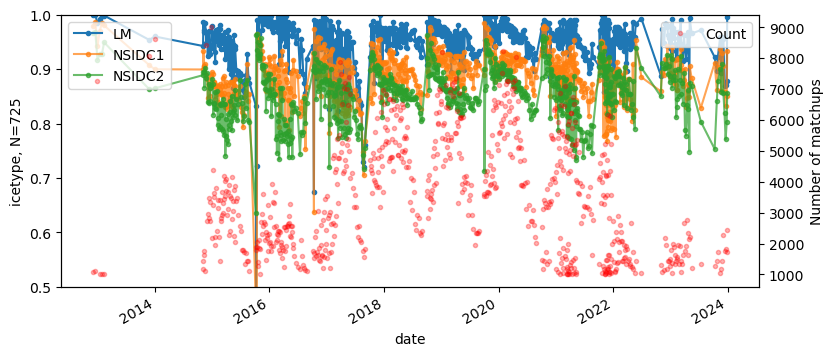

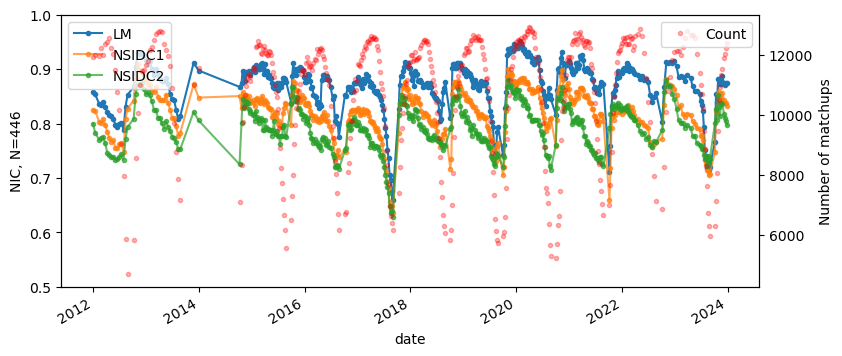

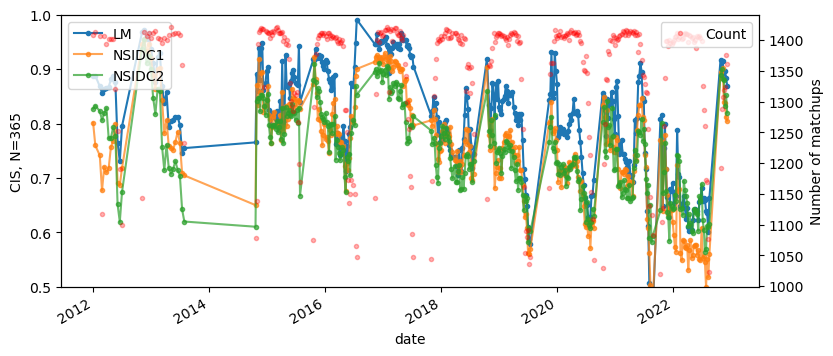

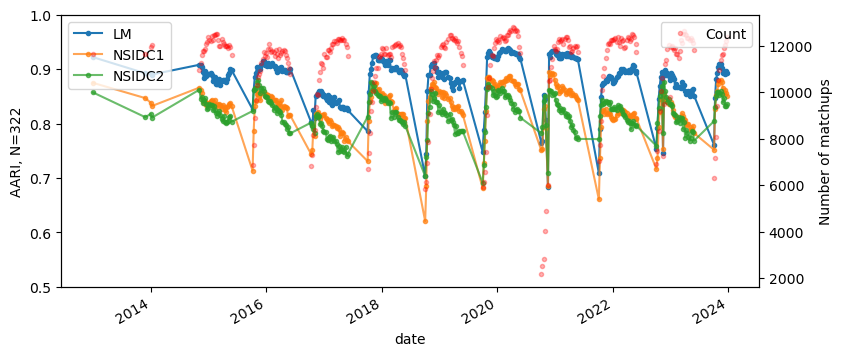

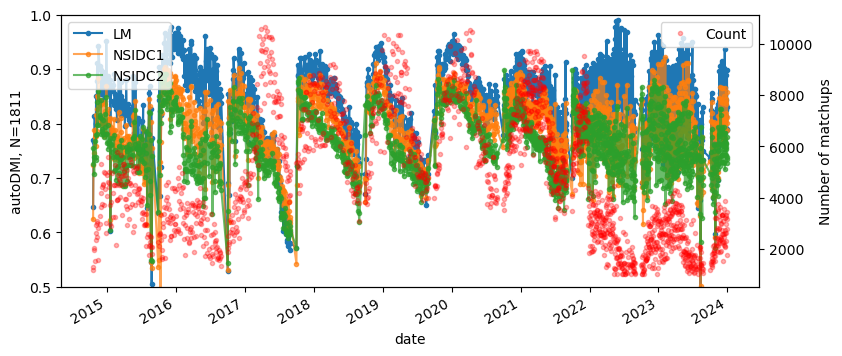

In [6]:
min_size = 1000
warnings.filterwarnings('ignore', category=UserWarning)

for name in scores:
    fig = plt.figure(figsize=(9, 4))
    mask = (scores[name]['count'] >= min_size) & (scores[name].index.month != 9)
    sub_scores = scores[name][mask]
    sub_scores['bac_lm'].plot(label='LM', style='.-')
    sub_scores['bac_newdc'].plot(label='NSIDC1', alpha=0.7, style='.-')
    sub_scores['bac_nsidc'].plot(label='NSIDC2', alpha=0.7, style='.-')
    
    plt.ylim(0.5, 1)
    plt.legend(loc='upper left')
    plt.ylabel(f'{name.split("_")[0]}, N={sub_scores.shape[0]}')
    ax2 = plt.twinx()
    ax2.plot(sub_scores.index, sub_scores['count'].values, 'r.', label='Count', alpha=0.3)
    #plt.xlim(datetime(2020,9,1), datetime(2020,12,31))
    #plt.title(f'Balanced Accuracy, ')
    plt.ylabel('Number of matchups')
    plt.legend(loc='upper right')
    plt.show()
    

In [7]:
comas['aggregated_'] = []
for name in comas:
    if name == 'icetype_matches' or name == 'aggregated_' or name == 'combined_':
        continue
    mask = (scores[name]['count'] >= min_size) & (scores[name].index.month != 9)
    comas['aggregated_'].append(comas[name][mask])
comas['aggregated_'] = np.concatenate(comas['aggregated_'], axis=0)
print('Created aggregated_ confusion matrix array.', comas['aggregated_'].shape)

Created aggregated_ confusion matrix array. (2944, 3, 2, 2)


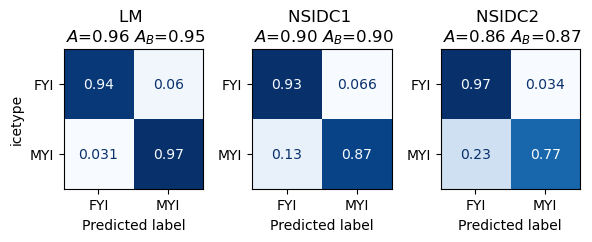

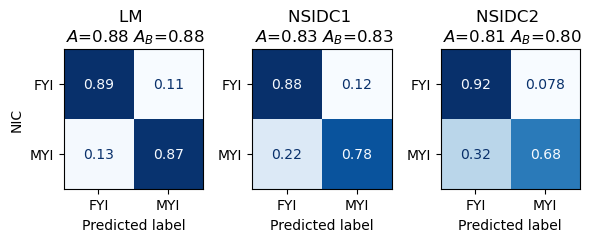

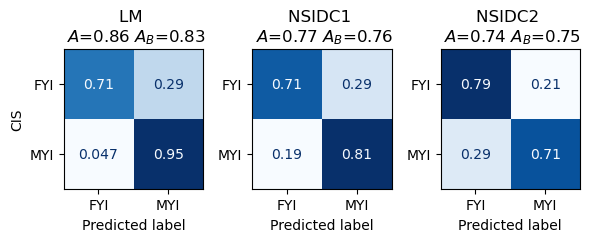

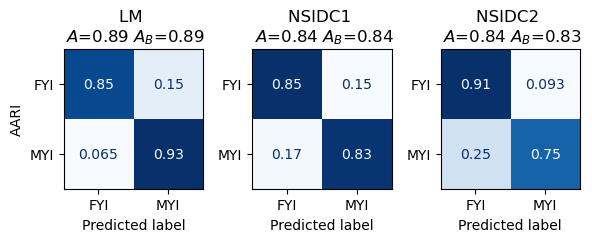

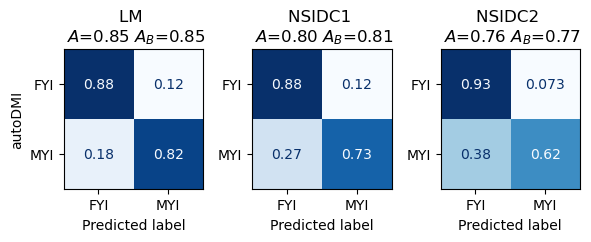

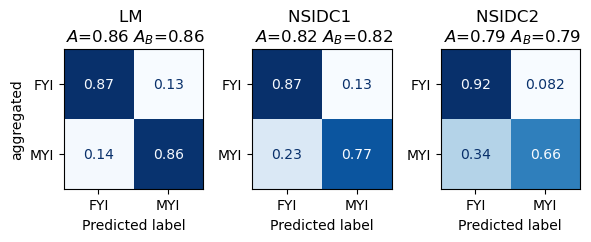

In [8]:
for name in comas:
    if name != 'combined_' and name != 'aggregated_':
        mask = (scores[name]['count'] >= min_size) & (scores[name].index.month != 9)
    else:
        mask = np.ones(comas[name].shape[0], dtype=bool)
    alg_labels = ['LM', 'NSIDC1', 'NSIDC2']
    fig, axs = plt.subplots(1, 3, figsize=(6,3))
    for i in range(3):
        coma = comas[name][mask, i].sum(axis=0)
        coma_normalized = coma.astype('float') / coma.sum(axis=1)[:, np.newaxis]
        disp = ConfusionMatrixDisplay(confusion_matrix=coma_normalized, display_labels=['FYI', 'MYI'])
        disp.plot(ax=axs[i], cmap=plt.cm.Blues, colorbar=False)
        accuracy = np.trace(coma) / np.sum(coma)
        balanced_accuracy = np.mean(np.diag(coma_normalized))
        axs[i].set_title(f'{alg_labels[i]} \n $A$={accuracy:0.2f} $A_B$={balanced_accuracy:0.2f}')
    axs[0].set_ylabel(name.split("_")[0])
    axs[1].set_ylabel('')
    axs[2].set_ylabel('')
    #fig.suptitle(name.split("_")[0])
    plt.tight_layout()
    plt.show()

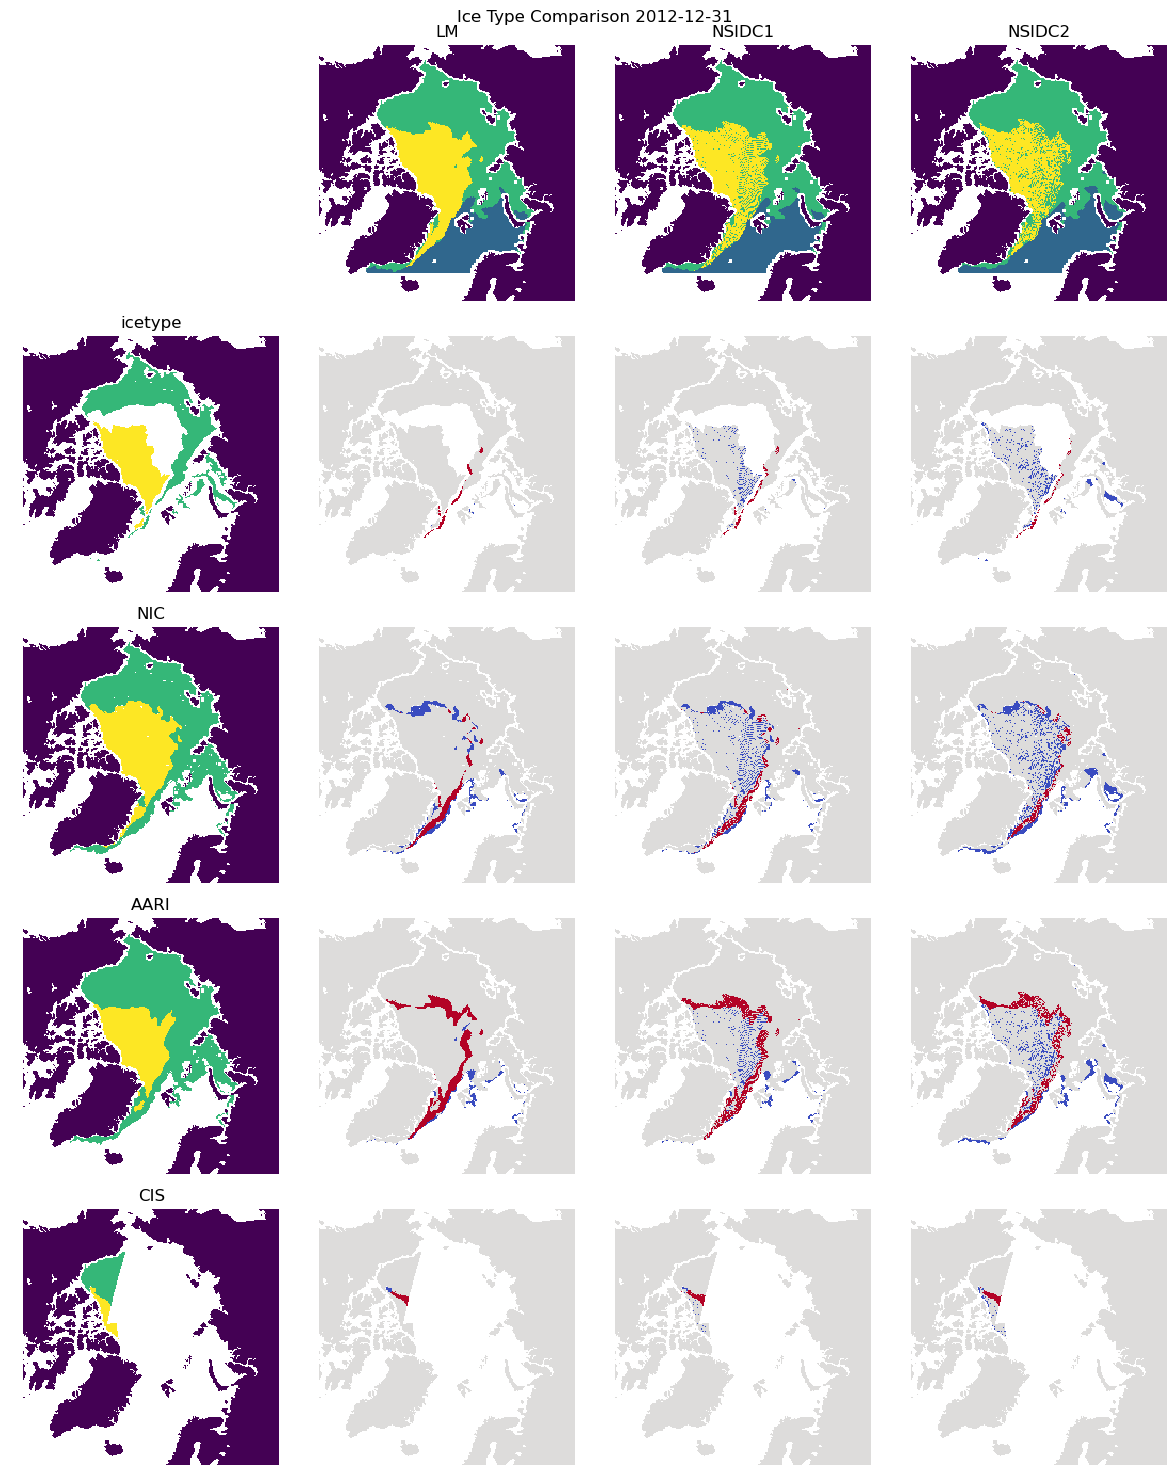

In [10]:
plot_date_start = datetime(2012, 12, 31)
plot_dates = [d for d in rrdp_dates if d >= plot_date_start][:1]

for plot_date in plot_dates:
    rf = rrdp_files[rrdp_dates.index(plot_date)]
    cf = coll_files[rrdp_dates.index(plot_date)]
    ice_type = {}
    rrdp_icetypes_plot = []
    with xr.open_dataset(rf) as ds:
        for rrdp_icetype in rrdp_icetypes:
            if rrdp_icetype in ds:
                ice_type[rrdp_icetype] = ds[rrdp_icetype][0].values
                rrdp_icetypes_plot.append(rrdp_icetype)

    lagr_algos_plot = []
    with xr.open_dataset(cf) as ds:
        for lagr_algo in lagr_algos:
            ice_type[lagr_algo] = ds[f'{lagr_algo}_ice_type'][0].values
            lagr_algos_plot.append(lagr_algo)
        
    for name in ice_type:
        ice_type[name][ice_type[name] == 1] = 2
        ice_type[name][ice_type[name] >= 3] = 4
        
    land_mask = ice_type['lm'] == -2
    valid_mask = np.isfinite(ice_type['lm']) & (ice_type['lm'] >= 0) & np.isfinite(ice_type['newdc']) & (ice_type['newdc'] >= 0) & np.isfinite(ice_type['nsidc']) & (ice_type['nsidc'] >= 0)
    lagr_titles = ['LM', 'NSIDC1', 'NSIDC2']
    plt_rows, plt_cols = len(rrdp_icetypes_plot) + 1, len(lagr_algos_plot) + 1
    fig, axs = plt.subplots(plt_rows, plt_cols, figsize=(plt_cols*3, plt_rows*3))
    for i, algo in enumerate(lagr_algos_plot):
        plt_array = ice_type[algo]
        plt_array[~valid_mask] = np.nan
        plt_array[land_mask] = -2
        im = axs[0, i+1].imshow(plt_array, vmin=-2, vmax=4, cmap='viridis', interpolation='none')
        axs[0, i+1].set_title(lagr_titles[i])
        axs[0, i+1].axis('off')
    for j, rrdp_icetype in enumerate(rrdp_icetypes_plot):
        plt_array = ice_type[rrdp_icetype]
        plt_array[~valid_mask] = np.nan
        plt_array[land_mask] = -2
        im = axs[j+1, 0].imshow(plt_array, vmin=-2, vmax=4, cmap='viridis', interpolation='none')
        axs[j+1, 0].set_title(rrdp_icetype.split('_')[0])
        axs[j+1, 0].axis('off')
        for i, algo in enumerate(lagr_algos_plot):
            im = axs[j+1, i+1].imshow(ice_type[algo] - ice_type[rrdp_icetype], vmin=-2, vmax=2, cmap='coolwarm', interpolation='none')
            axs[j+1, i+1].axis('off')
    plt.suptitle(f'Ice Type Comparison {plot_date.strftime("%Y-%m-%d")}')
    axs[0,0].axis('off')
    plt.tight_layout()
    plt.show()